# Titanic dataset

### Attributes
1. survived - Survival (0 = No; 1 = Yes)
2. pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
3. name - Name
4. sex - Sex
5. age - Age
6. sibsp - Number of Siblings/Spouses Aboard
7. parch - Number of Parents/Children Aboard
8. ticket - Ticket Number
9. fare - Passenger Fare
10. cabin - Cabin
11. embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = 12. Southampton)
12. boat - Lifeboat
13. body - Body number (if did not survive and body was recovered)
14. home.dest - Hometown

In [1]:
# Open the ipython console
%qtconsole --JupyterWidget.font_size=11

In [464]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import ShuffleSplit
from importlib import reload
import utils
reload(utils)
from utils import *
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm
from IPython.display import display

# set some plotting parameters
plt.rcParams.update({
    'font.size': 15,
    'axes.titlesize': 'medium'})
figsize = (10,3.5)
xlimits_bar = [-1,2]
xlimits_box = [0,3]
bar_width = .5

# utility function to convert from string to float, which handles missing 
# values as NaNs
nan_float = lambda data: np.array([np.nan if x=='?' else float(x) for x in data])

In [3]:
# load dataset
data_path = 'https://www.openml.org/data/get_csv/16826755/phpMYEkMl'
data = pd.read_csv(data_path)

data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [378]:
# extract relevant data attributes
features = {
    'survived': 1.*data['survived'].to_numpy(), # 0 = didn't survive, 1 = survived
    'boat': 1.*(data['boat'].to_numpy()!='?'), # 0 = didn't board a lifeboat, 1 = boarded a lifeboat 
    'sex': 1.*(data['sex'].to_numpy()=='female'), # 0 = 'male', 1 = 'female'
    'pclass': data['pclass'].to_numpy(),
    'age': nan_float(data['age']),
    'sibsp': data['sibsp'].to_numpy(),
    'parch': data['parch'].to_numpy(),
    'fare': nan_float(data['fare'])
    }

# prettier names for (some) features
feat_pretty = {
    'survived': 'survived',
    'boat': 'lifeboat',
    'sex': 'gender',
    'pclass': 'class',
    'age': 'age',
    'sibsp': 'siblings/spouses',
    'parch': 'parents/children',
    'fare': 'fare'}

# number of examples
m = len(data)

# print some quick information about the dataset
print('Dataset size: %d' % m)
print('Number of survivors: %d (%.2f %%)' % \
      (np.sum(features['survived']), 100*np.sum(features['survived'])/m))
print('Number of people who boarded a lifeboat: %d (%.2f %%)' % \
      (np.sum(features['boat']), 100*np.sum(features['boat'])/m))
print('Survivors on lifeboats: %d (%.2f %%)' % \
       (np.sum(1.*np.logical_and(features['survived'],features['boat'])),
        100*np.sum(1.*np.logical_and(features['survived'],features['boat']))/np.sum(features['boat'])))
print('Survivors off lifeboats: %d (%.2f %%)' % \
       (np.sum(1.*np.logical_and(features['survived'],np.logical_not(features['boat']))),
        100*np.sum(1.*np.logical_and(features['survived'],np.logical_not(features['boat'])))/np.sum(np.logical_not(features['boat']))))

# show the count of missing values per feature
print('\n# of missing values:')
print(*[key+': %d'%(np.sum(np.isnan(value))) for key,value in features.items()], sep="\n")

Dataset size: 1309
Number of survivors: 500 (38.20 %)
Number of people who boarded a lifeboat: 486 (37.13 %)
Survivors on lifeboats: 477 (98.15 %)
Survivors off lifeboats: 23 (2.79 %)

# of missing values:
survived: 0
boat: 0
sex: 0
pclass: 0
age: 263
sibsp: 0
parch: 0
fare: 1


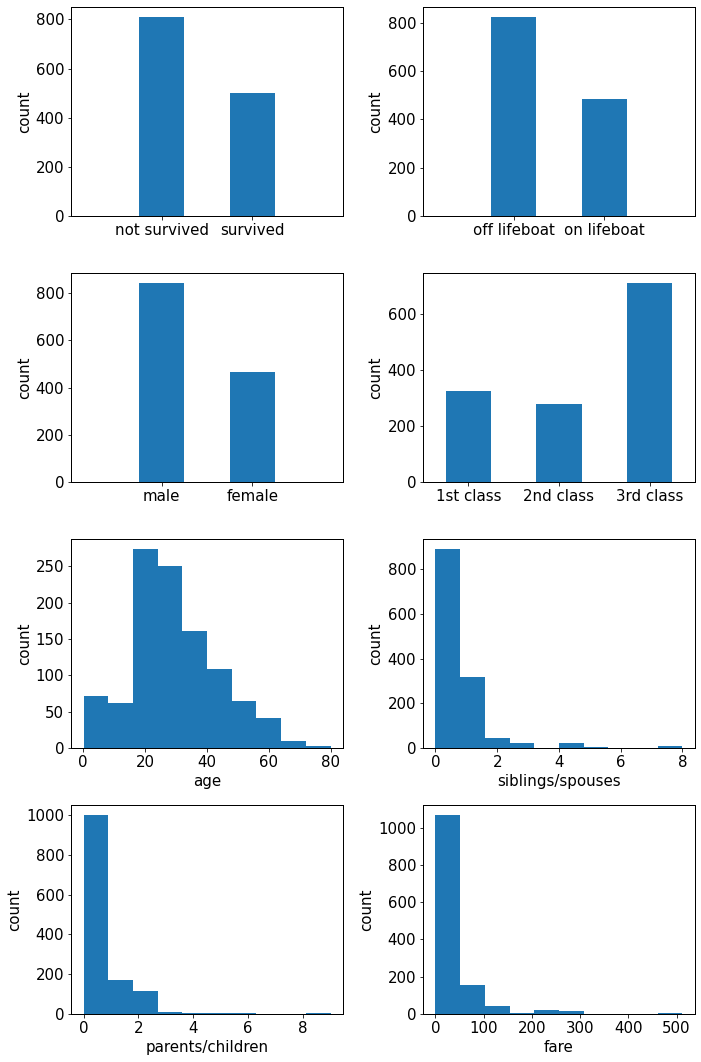

In [379]:
# show feature histograms
plt.figure(figsize=(10,15))
for k,item in enumerate(features.items()):
    plt.subplot(4,2,k+1)
    if item[0]=='survived':
        labels, counts = np.unique(item[1], return_counts=True)
        plt.bar(labels, counts, align='center', width=bar_width)
        plt.xticks(ticks=labels, labels=['not survived','survived'])
        plt.xlim((-1,2))
    elif item[0]=='boat':
        labels, counts = np.unique(item[1], return_counts=True)
        plt.bar(labels, counts, align='center', width=bar_width)
        plt.xticks(ticks=labels, labels=['off lifeboat','on lifeboat'])
        plt.xlim((-1,2))
    elif item[0]=='sex':
        labels, counts = np.unique(item[1], return_counts=True)
        plt.bar(labels, counts, align='center', width=bar_width)
        plt.xticks(ticks=labels, labels=['male','female'])
        plt.xlim((-1,2))
    elif item[0]=='pclass':
        labels, counts = np.unique(item[1], return_counts=True)
        plt.bar(labels, counts, align='center', width=bar_width)
        plt.xticks(ticks=labels, labels=['1st class','2nd class', '3rd class'])
        plt.xlim((.5,3.5))
    else:
        plt.hist(item[1])
        plt.xlabel(feat_pretty[item[0]])
    plt.ylabel('count')   
plt.tight_layout()

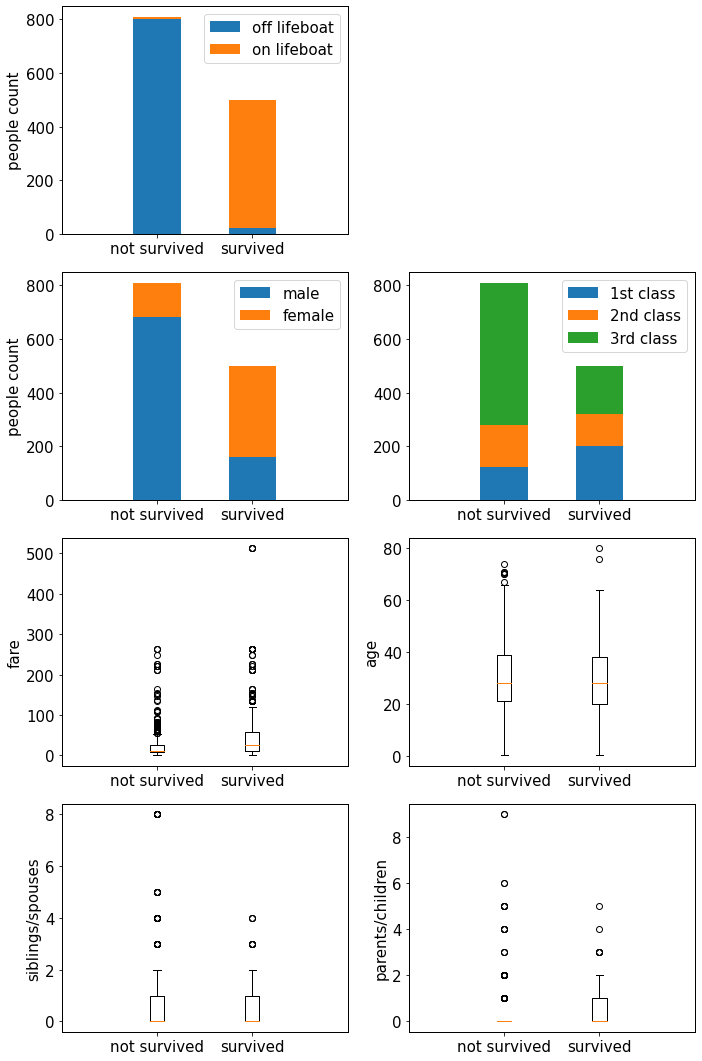

In [380]:
group = 'survived'
group_labels = ['not survived', 'survived']
plt.figure(figsize=(10,15))

# survivor count on and off lifeboats
feat = 'boat'
labels, counts = np.unique(features[group][features[feat]==0], return_counts=True)
plt.subplot(421)
plt.bar(labels, counts, align='center', width=bar_width)
bottom = counts
_, counts = np.unique(features[group][features[feat]==1], return_counts=True)
plt.bar(labels, counts, align='center', bottom = bottom, width=bar_width)
plt.xticks(ticks=labels, labels=group_labels)
plt.ylabel('people count')
plt.xlim(xlimits_bar)
plt.legend(['off lifeboat','on lifeboat']);

# survivor count based on gender
feat = 'sex'
labels, counts = np.unique(features[group][features[feat]==0], return_counts=True)
plt.subplot(423)
plt.bar(labels, counts, align='center', width=bar_width)
bottom = counts
_, counts = np.unique(features[group][features[feat]==1], return_counts=True)
plt.bar(labels, counts, align='center', bottom = bottom, width=bar_width)
plt.xticks(ticks=labels, labels=group_labels)
plt.ylabel('people count')
plt.xlim(xlimits_bar)
plt.legend(['male','female']);

# survivor count based on class
feat = 'pclass'
labels, counts = np.unique(features[group][features[feat]==1], return_counts=True)
plt.subplot(424)
plt.bar(labels, counts, align='center', width=bar_width)
bottom = counts
_, counts = np.unique(features[group][features[feat]==2], return_counts=True)
plt.bar(labels, counts, align='center', bottom = bottom, width=bar_width)
bottom = bottom + counts
_, counts = np.unique(features[group][features[feat]==3], return_counts=True)
plt.bar(labels, counts, align='center', bottom = bottom, width=bar_width)
plt.xticks(ticks=labels, labels=group_labels)
#plt.ylabel('people count')
plt.xlim(xlimits_bar)
plt.legend(['1st class','2nd class','3rd class']);

# distribution of fare for survived and not survived group
feat = 'fare'
plt.subplot(425)
x = features[feat]
y = features[group][~np.isnan(x)]
x = x[~np.isnan(x)]
plt.boxplot([x[y==0],x[y==1]], labels=group_labels)
plt.xlim(xlimits_box)
plt.ylabel(feat_pretty[feat]);

# distribution of age for survived and not survived group
feat = 'age'
plt.subplot(426)
x = features[feat]
y = features[group][~np.isnan(x)]
x = x[~np.isnan(x)]
plt.boxplot([x[y==0],x[y==1]], labels=group_labels)
plt.xlim(xlimits_box)
plt.ylabel(feat_pretty[feat]);

# distribution of fare on and off lifeboats
feat = 'sibsp'
plt.subplot(427)
x = features[feat]
y = features[group][~np.isnan(x)]
x = x[~np.isnan(x)]
plt.boxplot([x[y==0],x[y==1]], labels=group_labels)
plt.xlim(xlimits_box)
plt.ylabel(feat_pretty[feat]);

# distribution of age on and off lifeboats
feat = 'parch'
plt.subplot(428)
x = features[feat]
y = features[group][~np.isnan(x)]
x = x[~np.isnan(x)]
plt.boxplot([x[y==0],x[y==1]], labels=group_labels)
plt.xlim(xlimits_box)
plt.ylabel(feat_pretty[feat]);

plt.tight_layout();

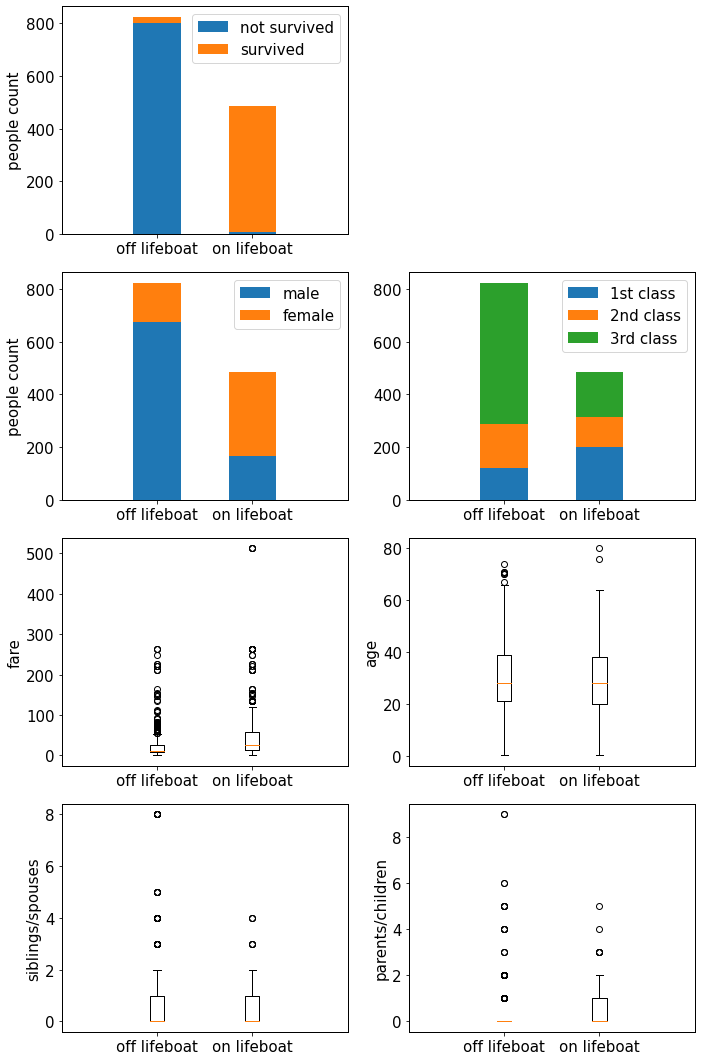

In [381]:
group = 'boat'
group_labels = ['off lifeboat', 'on lifeboat']
plt.figure(figsize=(10,15))

# survivor count on and off lifeboats
feat = 'survived'
labels, counts = np.unique(features[group][features[feat]==0], return_counts=True)
plt.subplot(421)
plt.bar(labels, counts, align='center', width=bar_width)
bottom = counts
_, counts = np.unique(features[group][features[feat]==1], return_counts=True)
plt.bar(labels, counts, align='center', bottom = bottom, width=bar_width)
plt.xticks(ticks=labels, labels=group_labels)
plt.ylabel('people count')
plt.xlim(xlimits_bar)
plt.legend(['not survived','survived']);

# lifeboat allocation based on gender
feat = 'sex'
labels, counts = np.unique(features[group][features[feat]==0], return_counts=True)
plt.subplot(423)
plt.bar(labels, counts, align='center', width=bar_width)
bottom = counts
_, counts = np.unique(features[group][features[feat]==1], return_counts=True)
plt.bar(labels, counts, align='center', bottom = bottom, width=bar_width)
plt.xticks(ticks=labels, labels=group_labels)
plt.ylabel('people count')
plt.xlim(xlimits_bar)
plt.legend(['male','female']);

# lifeboat allocation based on class
feat = 'pclass'
labels, counts = np.unique(features[group][features[feat]==1], return_counts=True)
plt.subplot(424)
plt.bar(labels, counts, align='center', width=bar_width)
bottom = counts
_, counts = np.unique(features[group][features[feat]==2], return_counts=True)
plt.bar(labels, counts, align='center', bottom = bottom, width=bar_width)
bottom = bottom + counts
_, counts = np.unique(features[group][features[feat]==3], return_counts=True)
plt.bar(labels, counts, align='center', bottom = bottom, width=bar_width)
plt.xticks(ticks=labels, labels=group_labels)
#plt.ylabel('people count')
plt.xlim(xlimits_bar)
plt.legend(['1st class','2nd class','3rd class']);

# distribution of fare on and off lifeboats
feat = 'fare'
plt.subplot(425)
x = features[feat]
y = features[group][~np.isnan(x)]
x = x[~np.isnan(x)]
plt.boxplot([x[y==0],x[y==1]], labels=group_labels)
plt.xlim(xlimits_box)
plt.ylabel(feat_pretty[feat]);

# distribution of age on and off lifeboats
feat = 'age'
plt.subplot(426)
x = features[feat]
y = features[group][~np.isnan(x)]
x = x[~np.isnan(x)]
plt.boxplot([x[y==0],x[y==1]], labels=group_labels)
plt.xlim(xlimits_box)
plt.ylabel(feat_pretty[feat]);

# distribution of fare on and off lifeboats
feat = 'sibsp'
plt.subplot(427)
x = features[feat]
y = features[group][~np.isnan(x)]
x = x[~np.isnan(x)]
plt.boxplot([x[y==0],x[y==1]], labels=group_labels)
plt.xlim(xlimits_box)
plt.ylabel(feat_pretty[feat]);

# distribution of age on and off lifeboats
feat = 'parch'
plt.subplot(428)
x = features[feat]
y = features[group][~np.isnan(x)]
x = x[~np.isnan(x)]
plt.boxplot([x[y==0],x[y==1]], labels=group_labels)
plt.xlim(xlimits_box)
plt.ylabel(feat_pretty[feat]);

plt.tight_layout();

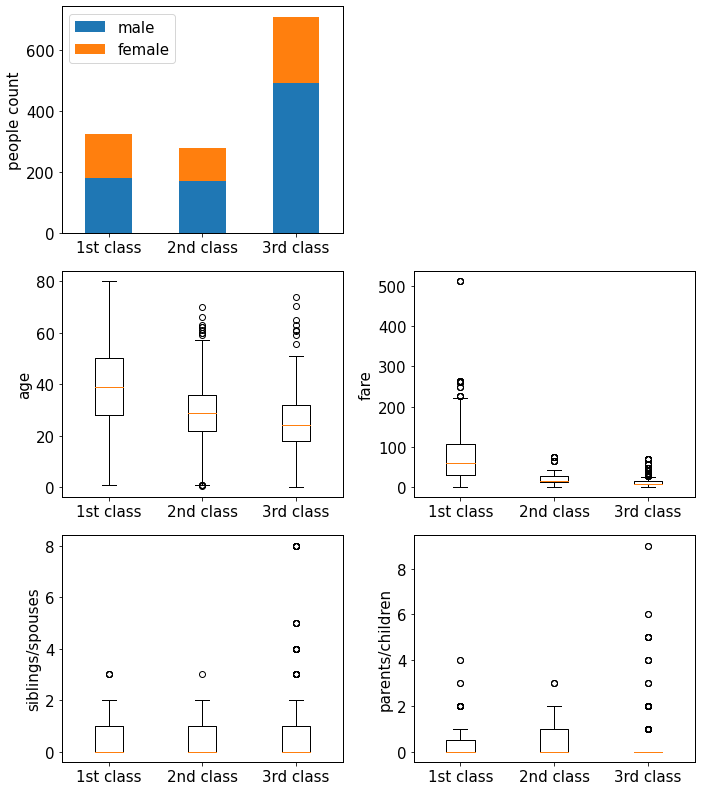

In [382]:
# show feature boxplots using 'class' as grouping variable
group = 'pclass'
group_labels = ['1st class', '2nd class', '3rd class']

plt.figure(figsize=(10,11.25))

# class allocation based on gender
feat = 'sex'
labels, counts = np.unique(features[group][features[feat]==0], return_counts=True)
plt.subplot(321)
plt.bar(labels, counts, align='center', width=bar_width)
bottom = counts
_, counts = np.unique(features[group][features[feat]==1], return_counts=True)
plt.bar(labels, counts, align='center', bottom = bottom, width=bar_width)
plt.xticks(ticks=labels, labels=group_labels)
plt.ylabel('people count')
plt.xlim((.5,3.5))
plt.legend(['male','female']);

curr_feat = 'age'
plt.subplot(323)
x = features[curr_feat]
y = features[group][~np.isnan(x)]
x = x[~np.isnan(x)]
plt.boxplot([x[y==1],x[y==2],x[y==3]], labels=group_labels)
plt.ylabel(feat_pretty[curr_feat]);

curr_feat = 'fare'
plt.subplot(324)
x = features[curr_feat]
y = features[group][~np.isnan(x)]
x = x[~np.isnan(x)]
plt.boxplot([x[y==1],x[y==2],x[y==3]], labels=group_labels)
plt.ylabel(feat_pretty[curr_feat]);

curr_feat = 'sibsp'
plt.subplot(325)
x = features[curr_feat]
y = features[group][~np.isnan(x)]
x = x[~np.isnan(x)]
plt.boxplot([x[y==1],x[y==2],x[y==3]], labels=group_labels)
plt.ylabel(feat_pretty[curr_feat]);

curr_feat = 'parch'
plt.subplot(326)
x = features[curr_feat]
y = features[group][~np.isnan(x)]
x = x[~np.isnan(x)]
plt.boxplot([x[y==1],x[y==2],x[y==3]], labels=group_labels)
plt.ylabel(feat_pretty[curr_feat]);

plt.tight_layout();

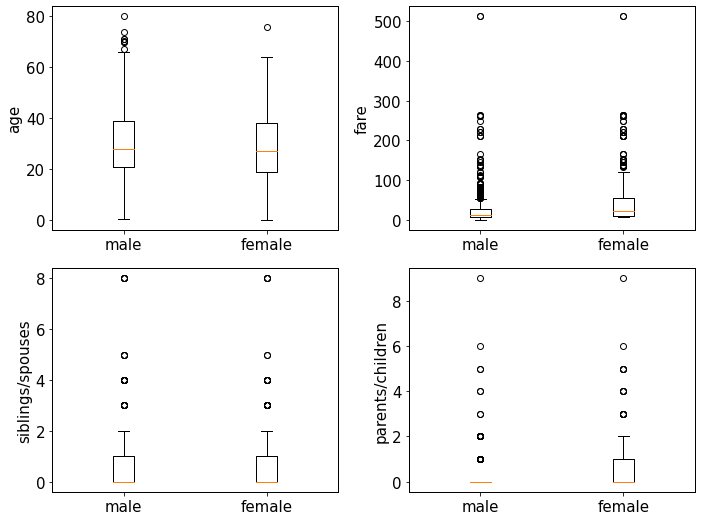

In [383]:
# show feature boxplots using 'class' as grouping variable
group = 'sex'

plt.figure(figsize=(10,7.5))

curr_feat = 'age'
plt.subplot(221)
x = features[curr_feat]
y = features[group][~np.isnan(x)]
x = x[~np.isnan(x)]
plt.boxplot([x[y==0],x[y==1]], labels=['male', 'female'])
plt.ylabel(feat_pretty[curr_feat]);

curr_feat = 'fare'
plt.subplot(222)
x = features[curr_feat]
y = features[group][~np.isnan(x)]
x = x[~np.isnan(x)]
plt.boxplot([x[y==0],x[y==1]], labels=['male', 'female'])
plt.ylabel(feat_pretty[curr_feat]);

curr_feat = 'sibsp'
plt.subplot(223)
x = features[curr_feat]
y = features[group][~np.isnan(x)]
x = x[~np.isnan(x)]
plt.boxplot([x[y==0],x[y==1]], labels=['male', 'female'])
plt.ylabel(feat_pretty[curr_feat]);

curr_feat = 'parch'
plt.subplot(224)
x = features[curr_feat]
y = features[group][~np.isnan(x)]
x = x[~np.isnan(x)]
plt.boxplot([x[y==0],x[y==1]], labels=['male', 'female'])
plt.ylabel(feat_pretty[curr_feat]);

plt.tight_layout();

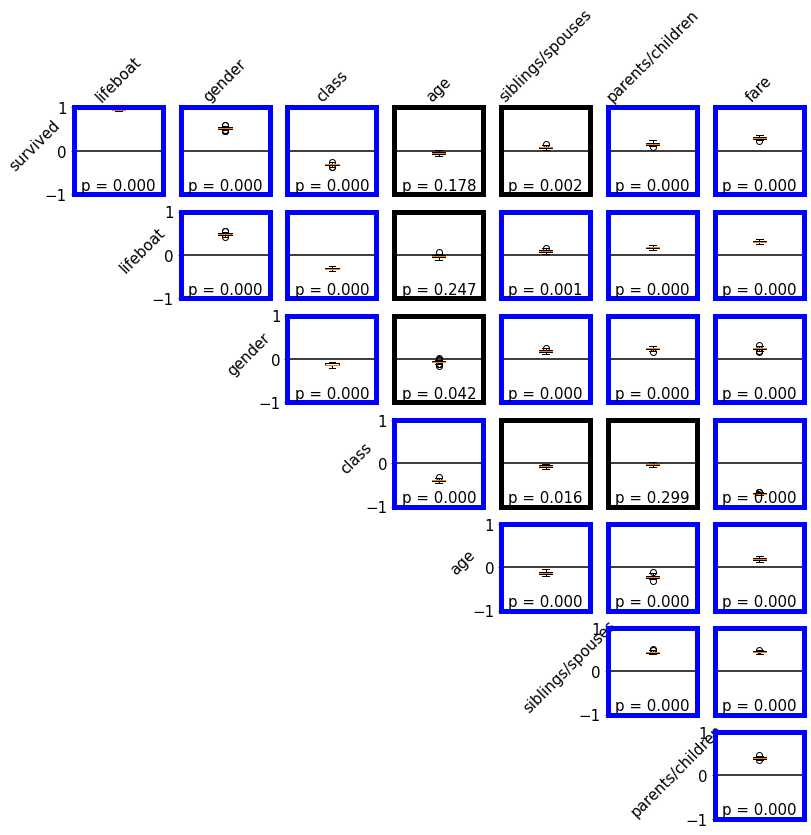

In [384]:
# show the correlation coefficient across features
nfeat = len(features)
pcount = 1
ntests = (nfeat**2 - nfeat)/2
stat_fun = spearmanr
plt.rc('axes', edgecolor='black', linewidth=5)

plt.figure(figsize=(15,15))
for i,item_i in enumerate(features.items()):
    for j,item_j in enumerate(features.items()):
        if j>i:
            # compute correlation distribution by bootstrapping
            r,r_av,r_ci = bootstrap(nan_reject([item_i[1], item_j[1]], match_list=True), 
                          stat_fun, 100)
            
            # compute p-values 
            _,p = stat_fun(*nan_reject([item_i[1], item_j[1]], match_list=True))
            
            # highlight the significant p-values (bonferroni corrected) in blue
            if p<.05/ntests:
                plt.rc('axes', edgecolor='blue')
            else:
                plt.rc('axes', edgecolor='black')
            
            plt.subplot(nfeat,nfeat,pcount)
            #plt.scatter(0, r_av)
            #plt.vlines(0, r_ci[0], r_ci[1])
            plt.boxplot(r)
            plt.hlines(0, *plt.xlim(), color='k')
            plt.text(plt.xlim()[0] + .5*np.diff(plt.xlim()),-.9,'p = %.3f'%p,
                    horizontalalignment='center')
            plt.xticks(ticks=[])
            plt.ylim((-1,1))
            if i==0: plt.title(feat_pretty[item_j[0]], rotation=45)
            if j==i+1: plt.ylabel(feat_pretty[item_i[0]], rotation=45)
            if j!=i+1: plt.yticks(ticks=[])
        
        pcount += 1
        
plt.rc('axes', edgecolor='black', linewidth=1)

In [385]:
def standardize(X_keys, cat_list=['boat','sex']):
    '''
    
    Feature standardization routine. 
    
    '''
    is_categorical = ismember(X_keys, cat_list)
    if all(is_categorical):
        return StandardScaler(with_mean=False, with_std=False)
    elif not any(is_categorical):
        return StandardScaler()
    else:
        return ColumnTransformer([
            ('cat', StandardScaler(with_mean=False, with_std=False), is_categorical),
            ('noncat', StandardScaler(), np.logical_not(is_categorical))])

def cross_validate_logit(X, Y, X_keys, verbose=False):
    '''
    
    Routine to cross-validate the logistic regression model.
    
    '''
    
    # specify logistic regression model
    logit = LogisticRegression(penalty='l2', solver='liblinear', class_weight='balanced')

    # specify processing pipeline
    pipeline = make_pipeline(standardize(X_keys), logit)

    # specify cross-validation iterator
    shuffle_split = ShuffleSplit(n_splits=100, test_size=.5, random_state=0)
    
    # reject remaining examples with missing values
    sel_idx = np.squeeze(np.argwhere(np.sum(np.isnan(X),axis=1)==0))
    Y = Y[sel_idx]
    X = X[sel_idx,:]

    # print number of features and examples
    if verbose:
        m,n = np.shape(X)
        print('# of examples: %d' % m)
        print('# of features: %d' % n)
        print('features: %s' % X_keys)
        print('survival rate: %.2f' % (np.sum(Y)/len(Y)))
    
    # perform crossvalidation
    cv_result = cross_validate(pipeline, X, Y, 
                               return_train_score=True, 
                               return_estimator=True,
                               cv=shuffle_split)
    
    return cv_result

# of examples: 1045
# of features: 6
features: ['sex', 'pclass', 'age', 'sibsp', 'parch', 'fare']
survival rate: 0.41


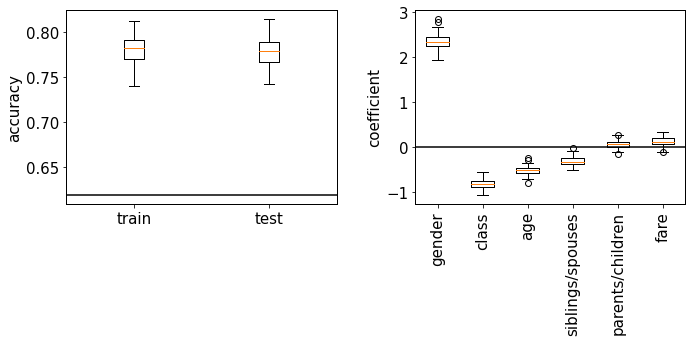

In [387]:
# variable to predict
Y = features['survived']

# feature selection
X_keys = ['sex','pclass','age','sibsp','parch','fare']
X = np.column_stack([features[key] for key in X_keys])

# cross-validate logistic regression model
cv_result = cross_validate_logit(X, Y, X_keys, verbose=True)

# extract model coefficients
cv_coef = np.concatenate(
    [x.steps[1][1].coef_ for x in cv_result['estimator']], axis=0)

# plot
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.boxplot([cv_result['train_score'], cv_result['test_score']], \
           labels=['train', 'test'])
plt.hlines(1-np.sum(Y)/len(Y), plt.xlim()[0], plt.xlim()[1], color='k');
#plt.ylim((0,1))
plt.ylabel('accuracy')
plt.subplot(122)
plt.boxplot(cv_coef, labels=[feat_pretty[key] for key in X_keys])
plt.xticks(rotation=90)
plt.ylabel('coefficient')
plt.hlines(0, plt.xlim()[0], plt.xlim()[1], color='k')
plt.tight_layout();

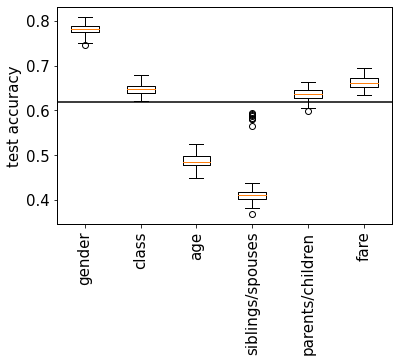

In [389]:
feat_to_predict = 'survived'
X_keys_list = ['sex','pclass','age','sibsp','parch','fare']

test_scores = []
for curr_key in X_keys_list:
    # variable to predict
    Y = features[feat_to_predict]
    
    # feature selection
    X_keys = [curr_key]
    X = np.column_stack([features[key] for key in X_keys])

    # cross-validate logistic regression model
    cv_result = cross_validate_logit(X, Y, X_keys)
    
    # append test scores
    test_scores.append(cv_result['test_score'])

# plot
plt.figure()
plt.boxplot(test_scores, labels=[feat_pretty[key] for key in X_keys_list])
plt.xticks(rotation=90)
Y = features[feat_to_predict]
plt.hlines(1-np.sum(Y)/len(Y), plt.xlim()[0], plt.xlim()[1], color='k')
plt.ylabel('test accuracy');

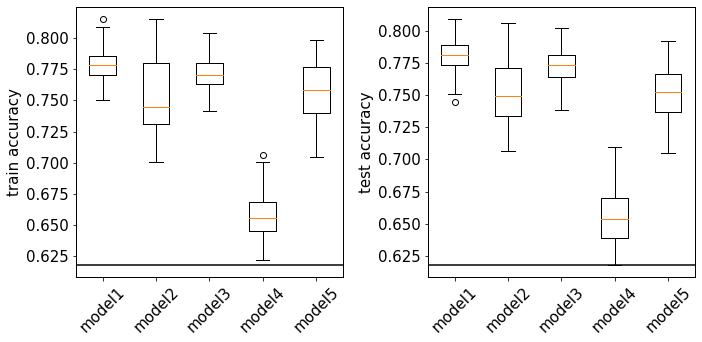

In [470]:
feat_to_predict = 'survived'
model_specs = {
    'model1': ['sex'],
    'model2': ['sex', 'pclass'],
    'model3': ['sex', 'fare'],
    'model4': ['pclass', 'fare'],
    'model5': ['sex', 'pclass', 'fare']}

train_scores = []
test_scores = []
for curr_key in model_specs.values():
    # variable to predict
    Y = features[feat_to_predict]
    
    # feature selection
    X_keys = curr_key
    X = np.column_stack([features[key] for key in X_keys])

    # cross-validate logistic regression model
    cv_result = cross_validate_logit(X, Y, X_keys)
    
    # append train/test scores
    train_scores.append(cv_result['train_score'])
    test_scores.append(cv_result['test_score'])

# plot
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.boxplot(train_scores, labels=model_specs.keys())
plt.xticks(rotation=45)
Y = features[feat_to_predict]
plt.hlines(1-np.sum(Y)/len(Y), plt.xlim()[0], plt.xlim()[1], color='k')
plt.ylabel('train accuracy');
plt.subplot(122)
plt.boxplot(test_scores, labels=model_specs.keys())
plt.xticks(rotation=45)
Y = features[feat_to_predict]
plt.hlines(1-np.sum(Y)/len(Y), plt.xlim()[0], plt.xlim()[1], color='k')
plt.ylabel('test accuracy');
plt.tight_layout();

In [467]:
# variable to predict
feat_to_predict = 'survived'
Y = features[feat_to_predict]

# feature selection
X_keys = ['boat','sex','pclass','age','sibsp','parch','fare']
X = np.column_stack([features[key] for key in X_keys])

# feature standardization
X = standardize(X_keys).fit(X).transform(X)

# create data frame
data_frame = pd.DataFrame(
    data = np.column_stack([Y,X]), 
    columns = [feat_to_predict]+X_keys)
display(data_frame.head())

# fit logistic regression model(s)
#model_specs = feat_to_predict + " ~ sex + pclass + age + sibsp + parch + fare"
#model_specs = feat_to_predict + " ~ sex + pclass + age + sibsp"
#model_specs = "survived ~ sex*pclass + sex*age + sex*sibsp + sex*parch + sex*fare"
model_specs_list = [
    feat_to_predict + " ~ sex + pclass + age + sibsp + parch + fare",
    feat_to_predict + " ~ sex*pclass + sex*age + sex*sibsp + sex*parch + sex*fare"]
models = []
results = []
for k,model_specs in enumerate(model_specs_list):
    models.append(
        sm.GLM.from_formula(model_specs, family=sm.families.Binomial(), data=data_frame))
    results.append(models[k].fit())
    display(results[k].summary())

likelihood_ratio_test(results[0], results[1]);

,survived,boat,sex,pclass,age,sibsp,parch,fare
0,1.0,1.0,1.0,-1.546098,-0.061162,-0.479087,-0.445000,3.441165
1,1.0,1.0,0.0,-1.546098,-2.010496,0.481288,1.866526,2.285603
2,0.0,0.0,1.0,-1.546098,-1.935302,0.481288,1.866526,2.285603
3,0.0,0.0,0.0,-1.546098,0.008251,0.481288,1.866526,2.285603
4,0.0,0.0,1.0,-1.546098,-0.338812,0.481288,1.866526,2.285603


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               survived   No. Observations:                 1045
Model:                            GLM   Df Residuals:                     1038
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -485.19
Date:                Thu, 18 Feb 2021   Deviance:                       970.37
Time:                        16:17:20   Pearson chi2:                 1.08e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5396      0.110    -13.965      0.000      -1.756      -1.324
sex            2.5467      0.173     14.682      0.000       2.207       2.887
pclass        -0.9198      0.110     -8.364      0.000      -1.135      -0.704
age           -0.5534      0.094     -5.862      0.000      -0.738      -0.368
sibsp         -0.3694      0.110     -3.351      0.001      -0.585      -0.153
parch          0.0475      0.089      0.533      0.594      -0.127       0.222
fare           0.0849      0.098      0.865      0.387      -0.107       0.277
==============================================================================
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               survived   No. Observations:                 1045
Model:                            GLM   Df Residuals:                     1033
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -463.11
Date:                Thu, 18 Feb 2021   Deviance:                       926.21
Time:                        16:17:20   Pearson chi2:                 1.14e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4451      0.107    -13.501      0.000      -1.655      -1.235
sex            2.7038      0.198     13.675      0.000       2.316       3.091
pclass        -0.6280      0.129     -4.853      0.000      -0.882      -0.374
sex:pclass    -1.2108      0.287     -4.218      0.000      -1.773      -0.648
age           -0.6725      0.127     -5.298      0.000      -0.921      -0.424
sex:age        0.2612      0.212      1.230      0.219      -0.155       0.678
sibsp         -0.3510      0.146     -2.409      0.016      -0.637      -0.065
sex:sibsp     -0.0440      0.220     -0.200      0.842      -0.475       0.388
parch          0.2124      0.139      1.532      0.126      -0.059       0.484
sex:parch     -0.1994      0.181     -1.100      0.271      -0.555       0.156
fare           0.0652      0.120      0.545      0.586      -0.169       0.300
sex:fare      -0.2372      0.233     -1.018      0.309      -0.694       0.220
==============================================================================
"""

Likelihood ratio: 44.161
Degrees of freedom: 5
p-value: 2.1483280374178126e-08
